# <h1>Introduction<h1>

In [98]:
!pip install seaborn
!pip install wordcloud


In [99]:
import pandas as pd
import numpy as np
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import  MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score



import re
import nltk
import string

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from pathlib import Path
import glob
from collections import OrderedDict

from IPython.display import display

# data set

## import data

In [100]:
path_dataset = "D:/Git_desktop/NhapMonHocMay/dataset.csv"

display(df)

,text,label
0,I saw this fine flick shortly leaving college....,1
1,"A strong woman oriented subject after long, di...",1
2,I must say I was really excited about this fil...,0
3,This warning against anti-semitism is well-mea...,0
4,FOUR FRIENDS was first billed on HBO in 82 as ...,1
...,...,...
49995,I read somewhere that Hollywood should concent...,0
49996,My local PBS station WHYY Philadelphia recentl...,1
49997,Another popular screening for a British pictur...,1
49998,I thought this movie was horrible. I was bored...,0


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [102]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


label
1    25000
0    25000
Name: count, dtype: int64


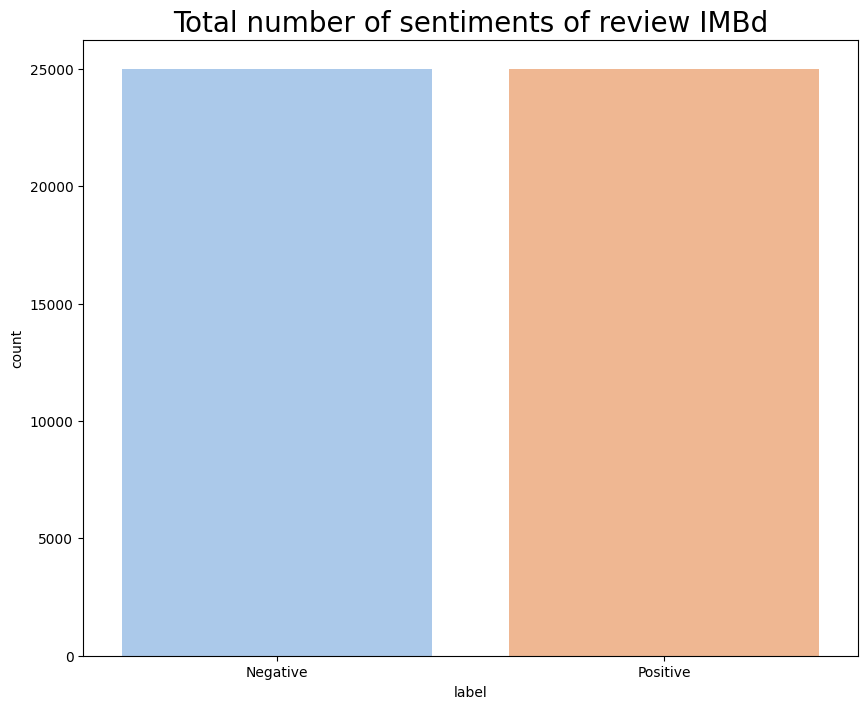

In [103]:
print(df.label.value_counts())
plt.figure(figsize = (10,8))
ax = sns.countplot(x= 'label', data = df, palette = 'pastel')
ax.set_title(label = 'Total number of sentiments of review IMBd', fontsize = 20)
ax.set_xticklabels(['Negative', 'Positive'], rotation = 0)
plt.show()

In [104]:
df["text_lower"] = df["text"].str.lower()
df[['text', 'text_lower']].head()

,text,text_lower
0,I saw this fine flick shortly leaving college....,i saw this fine flick shortly leaving college....
1,"A strong woman oriented subject after long, di...","a strong woman oriented subject after long, di..."
2,I must say I was really excited about this fil...,i must say i was really excited about this fil...
3,This warning against anti-semitism is well-mea...,this warning against anti-semitism is well-mea...
4,FOUR FRIENDS was first billed on HBO in 82 as ...,four friends was first billed on hbo in 82 as ...


In [105]:
def remove_punctuation(text):
  """custom function to remove the punctuation"""
  return re.sub(r'[^\w\s]', '', text)
  
df["text_wo_punct"] = df["text_lower"].apply(lambda text: remove_punctuation(text))
df[['text_lower', 'text_wo_punct']].head()

,text_lower,text_wo_punct
0,i saw this fine flick shortly leaving college....,i saw this fine flick shortly leaving college ...
1,"a strong woman oriented subject after long, di...",a strong woman oriented subject after long dir...
2,i must say i was really excited about this fil...,i must say i was really excited about this fil...
3,this warning against anti-semitism is well-mea...,this warning against antisemitism is wellmeant...
4,four friends was first billed on hbo in 82 as ...,four friends was first billed on hbo in 82 as ...


### remove stopwords

In [106]:
from nltk.corpus import stopwords
nltk.download('stopwords')
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngduc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [107]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df[['text_wo_punct', 'text_wo_stop']].head()

,text_wo_punct,text_wo_stop
0,i saw this fine flick shortly leaving college ...,saw fine flick shortly leaving college sat hap...
1,a strong woman oriented subject after long dir...,strong woman oriented subject long director kr...
2,i must say i was really excited about this fil...,must say really excited film renting adam sand...
3,this warning against antisemitism is wellmeant...,warning antisemitism wellmeant may purpose tim...
4,four friends was first billed on hbo in 82 as ...,four friends first billed hbo 82 sleeper hit h...


### Removal of Frequent words

In [108]:
from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('br', 113693),
 ('movie', 83499),
 ('film', 74443),
 ('one', 51019),
 ('like', 38986),
 ('good', 28568),
 ('even', 24570),
 ('would', 24024),
 ('time', 23250),
 ('really', 22946)]

In [109]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df[['text_wo_stop', 'text_wo_stopfreq']].head()

,text_wo_stop,text_wo_stopfreq
0,saw fine flick shortly leaving college sat hap...,saw fine flick shortly leaving college sat hap...
1,strong woman oriented subject long director kr...,strong woman oriented subject long director kr...
2,must say really excited film renting adam sand...,must say excited renting adam sandler happy ma...
3,warning antisemitism wellmeant may purpose tim...,warning antisemitism wellmeant may purpose mad...
4,four friends first billed hbo 82 sleeper hit h...,four friends first billed hbo 82 sleeper hit h...


### Removal of Rare words

In [110]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df[['text_wo_stopfreq', 'text_wo_stopfreqrare']].head()

,text_wo_stopfreq,text_wo_stopfreqrare
0,saw fine flick shortly leaving college sat hap...,saw fine flick shortly leaving college sat hap...
1,strong woman oriented subject long director kr...,strong woman oriented subject long director kr...
2,must say excited renting adam sandler happy ma...,must say excited renting adam sandler happy ma...
3,warning antisemitism wellmeant may purpose mad...,warning antisemitism wellmeant may purpose mad...
4,four friends first billed hbo 82 sleeper hit h...,four friends first billed hbo 82 sleeper hit h...


### Lemmatization

In [111]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatizer"] = df["text_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
df[['text_wo_stopfreqrare', 'text_lemmatizer']].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngduc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ngduc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ngduc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,text_wo_stopfreqrare,text_lemmatizer
0,saw fine flick shortly leaving college sat hap...,saw fine flick shortly leave college sit happi...
1,strong woman oriented subject long director kr...,strong woman orient subject long director kris...
2,must say excited renting adam sandler happy ma...,must say excited rent adam sandler happy madis...
3,warning antisemitism wellmeant may purpose mad...,warn antisemitism wellmeant may purpose make w...
4,four friends first billed hbo 82 sleeper hit h...,four friend first bill hbo 82 sleeper hit hear...


In [112]:
df['text'] = df['text_lemmatizer']

# Analysing the data

### Word-Cloud for Positive reviews

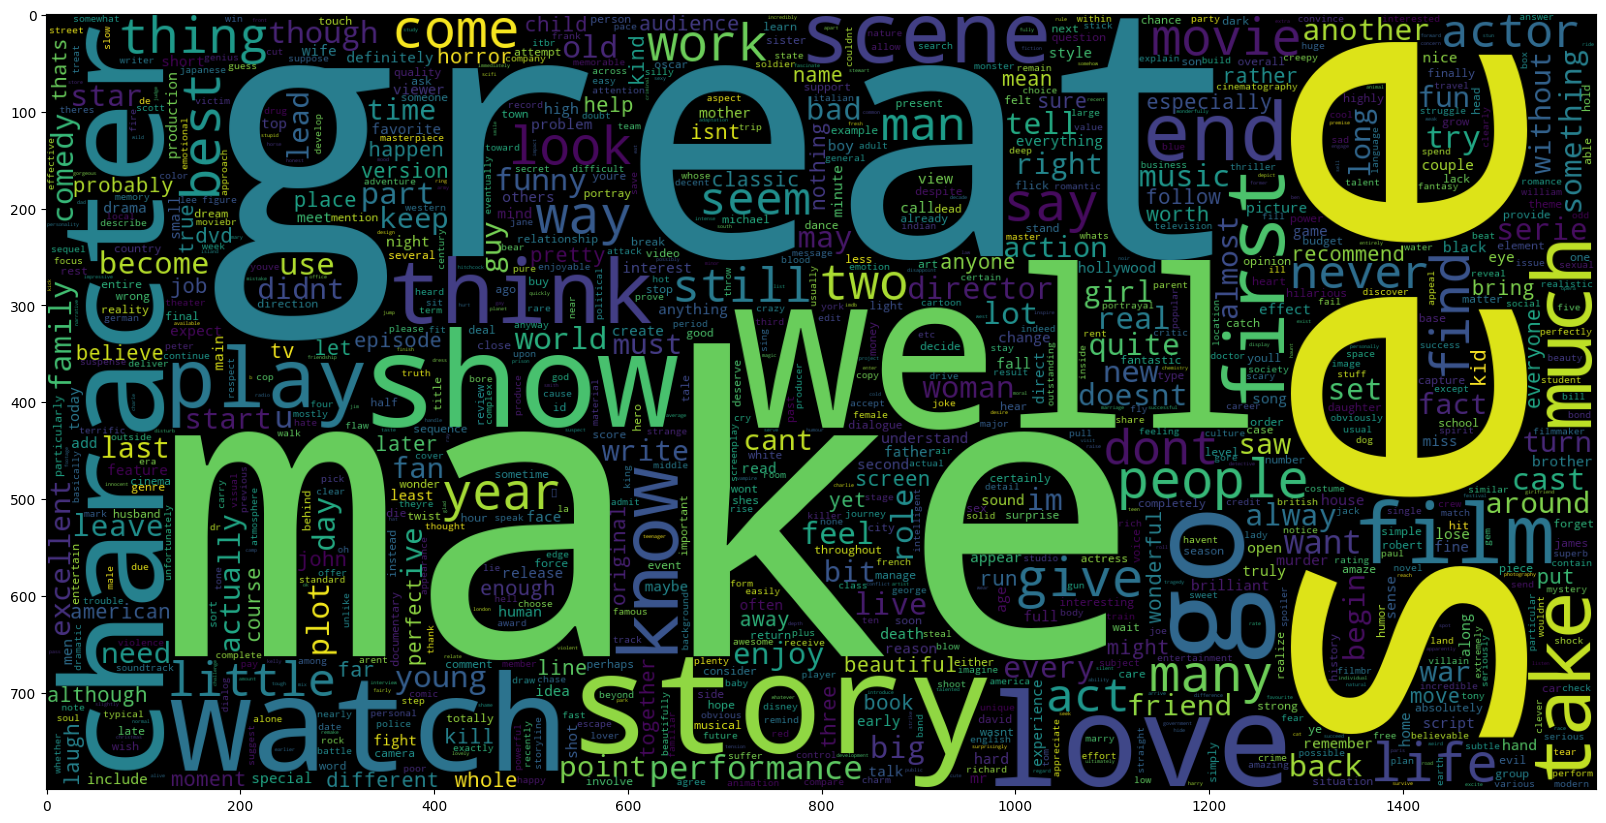

In [113]:
data_pos = df[df.label == 1]['text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

### Word-Cloud for Negative reviews

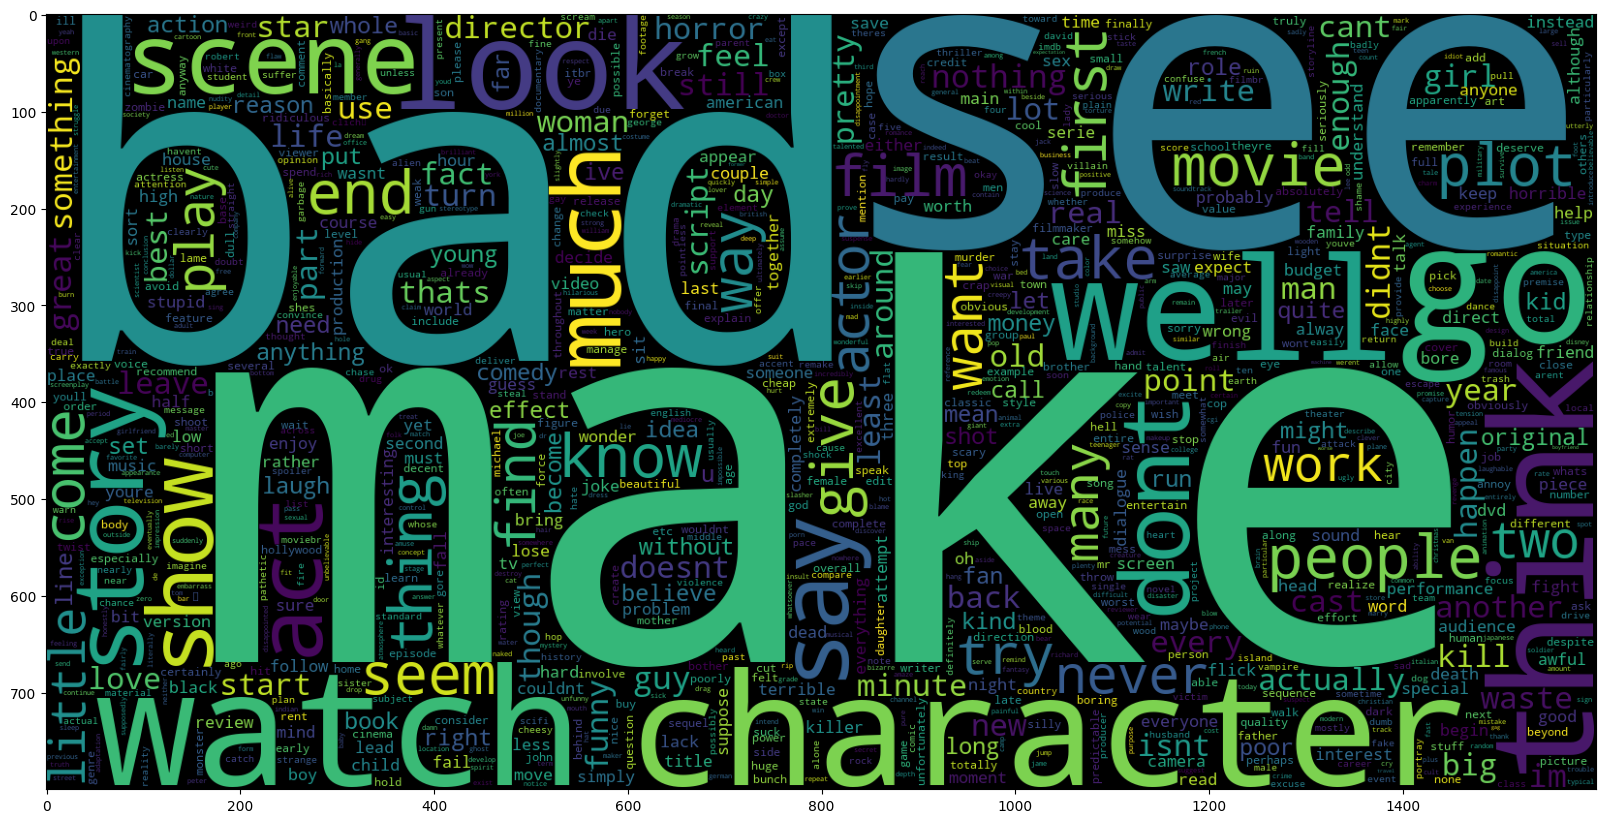

In [114]:
data_neg = df[df.label == 0]['text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

## max length and average length

In [115]:
def count_words(text):
    leng = len(text.split(" "))
    return leng

df["length"] = df["text"].apply(lambda text: count_words(text))

In [116]:
max(df["length"])

1417

In [117]:
sum(df['length'])/len(df['length'])

113.14582

In [118]:
print(df[df.length == 1417]['text'].astype(str))

46081    match 1 tag team table match bubba ray spike d...
Name: text, dtype: object


# Train Model


## tranforming the dataset

In [119]:
vectorizer = CountVectorizer()
text = ["hello we are group 1, there are our source code", "hello everyone"]
count_matrix = vectorizer.fit_transform(text)
count_array = count_matrix.toarray()
df1 = pd.DataFrame(data = count_array, columns = vectorizer.get_feature_names_out())
print(df1)

   are  code  everyone  group  hello  our  source  there  we
0    2     1         0      1      1    1       1      1   1
1    0     0         1      0      1    0       0      0   0


In [120]:
vectorizerCount = CountVectorizer()

In [121]:
all_features_Count = vectorizerCount.fit_transform(df.text)

## split data

In [122]:
test_size = 0.3
X_train_Count, X_test_Count, y_train_Count, y_test_Count = train_test_split(all_features_Count, 
                                                            df.label, 
                                                            test_size=test_size, 
                                                            random_state=42, 
                                                            stratify= df.label)

## model


### NB

In [123]:
classifier_nb_Count = MultinomialNB()
t = time.time()
classifier_nb_Count.fit(X_train_Count, y_train_Count)
time_for_train_nb = time.time()-t
print(f'Time Taken: {time_for_train_nb} seconds')

Time Taken: 0.04383492469787598 seconds


### KNN

In [124]:
classifier_knn_Count = KNeighborsClassifier(n_neighbors=7)
t = time.time()
classifier_knn_Count.fit(X_train_Count,y_train_Count)
time_for_train_knn = time.time()-t
print(f'Time Taken: {time_for_train_knn} seconds')

Time Taken: 0.013185262680053711 seconds


### SVM

In [125]:
# svm rbf
classifier_svm_rbf_Count = SVC(C = 1,kernel = 'rbf')
t = time.time()
classifier_svm_rbf_Count.fit(X_train_Count, y_train_Count)
time_for_train_svm_rbf = time.time()-t
print(f'Time Taken: {time_for_train_svm_rbf} seconds')

Time Taken: 1651.5902070999146 seconds


In [126]:
# svm linear
classifier_svm_linear_Count = SVC(C = 1,kernel = 'linear')
t = time.time()
classifier_svm_linear_Count.fit(X_train_Count, y_train_Count)
time_for_train_svm_linear = time.time()-t
print(f'Time Taken: {time_for_train_svm_linear} seconds')

Time Taken: 3696.547651052475 seconds


### decision tree

In [127]:
classifier_dtree_Count = DecisionTreeClassifier(criterion = 'entropy')
t = time.time()
classifier_dtree_Count.fit(X_train_Count, y_train_Count)
time_for_train_dtree = time.time()-t
print(f'Time Taken: {time_for_train_dtree} seconds')

Time Taken: 58.71317911148071 seconds


## Evalution

In [176]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = ['Negative', 'Positive']

def model_Evaluate(model):
    y_pred_Count = model.predict(X_test_Count)
    print(classification_report(y_test_Count, y_pred_Count))

    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
          y_test_Count,
          y_pred_Count,
          display_labels=class_names,
          cmap=plt.cm.Blues,
          normalize=normalize,
        )
        disp.ax_.set_title(title)
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

              precision    recall  f1-score   support

           0       0.59      0.83      0.69      7500
           1       0.71      0.41      0.52      7500

    accuracy                           0.62     15000
   macro avg       0.65      0.62      0.61     15000
weighted avg       0.65      0.62      0.61     15000



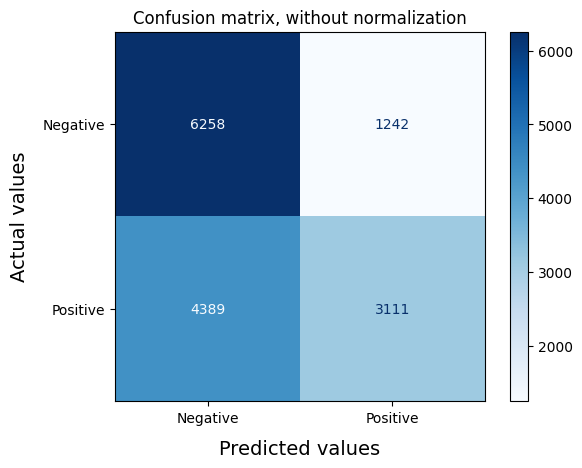

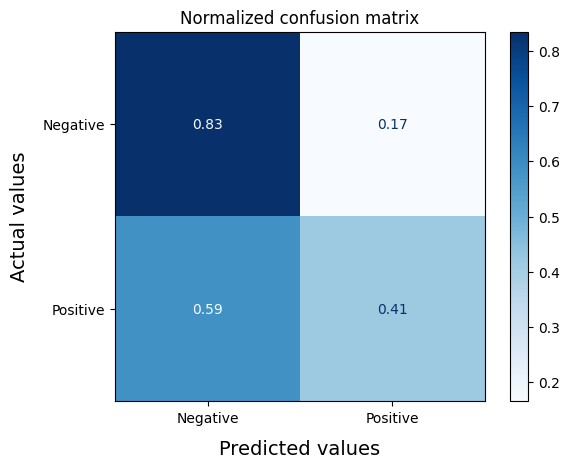

In [177]:
model_Evaluate(classifier_knn_Count)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7500
           1       0.87      0.84      0.85      7500

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



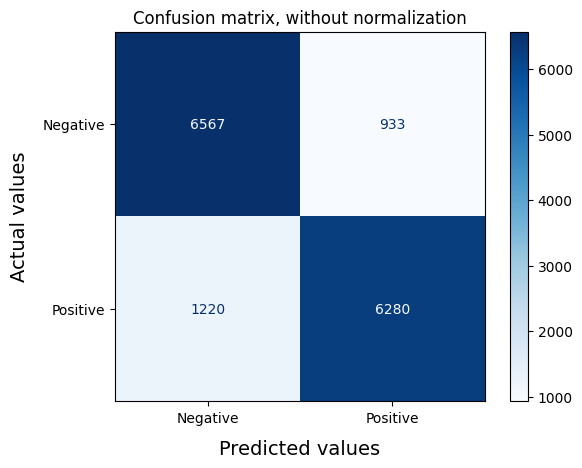

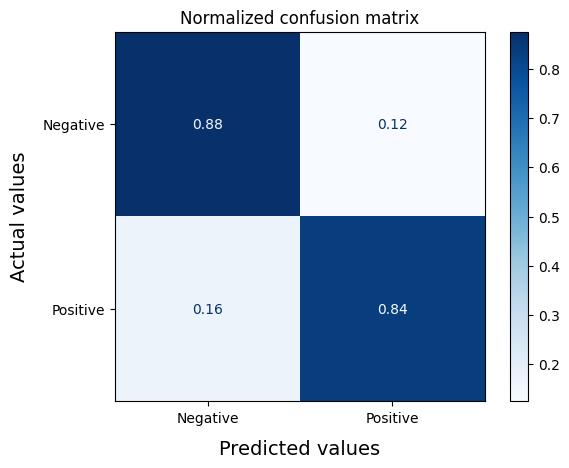

In [178]:
model_Evaluate(classifier_nb_Count)

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7500
           1       0.86      0.90      0.88      7500

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



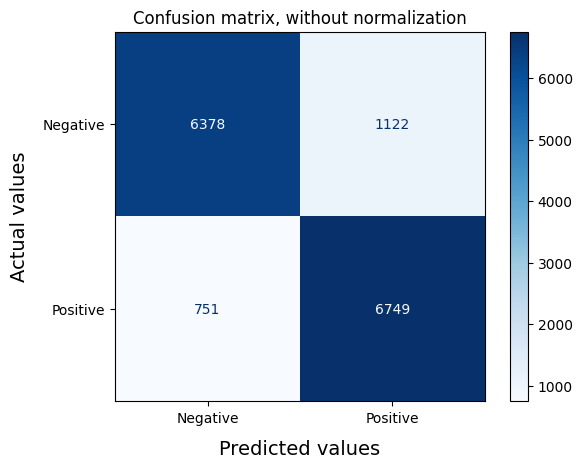

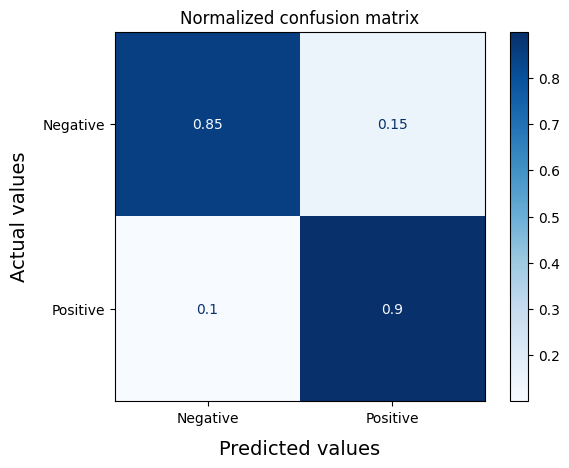

In [179]:
model_Evaluate(classifier_svm_rbf_Count)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      7500
           1       0.86      0.87      0.86      7500

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



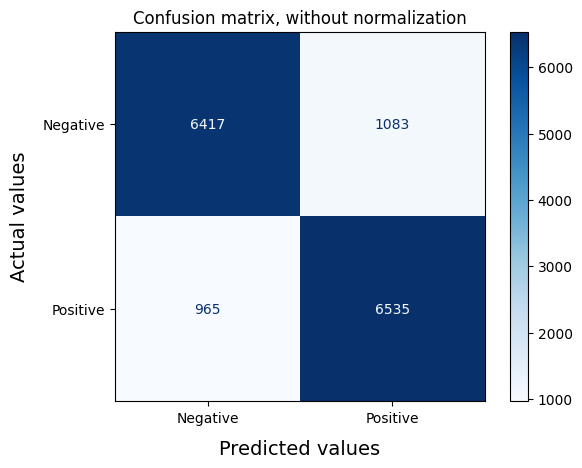

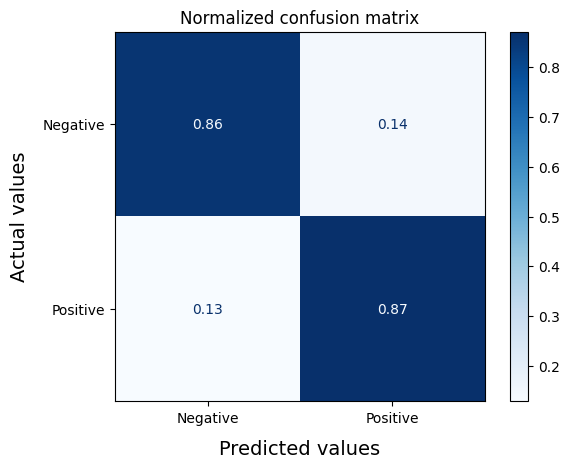

In [180]:
model_Evaluate(classifier_svm_linear_Count)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      7500
           1       0.72      0.72      0.72      7500

    accuracy                           0.72     15000
   macro avg       0.72      0.72      0.72     15000
weighted avg       0.72      0.72      0.72     15000



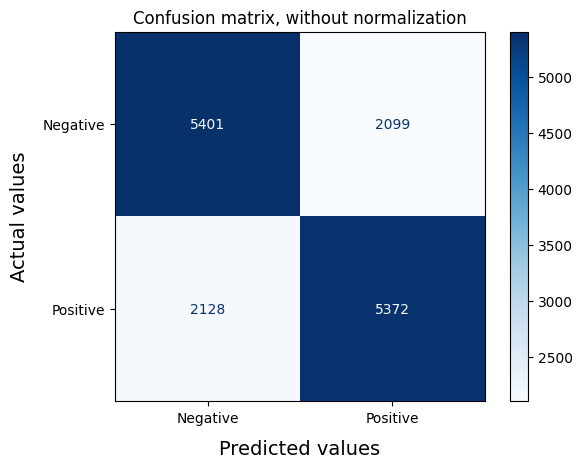

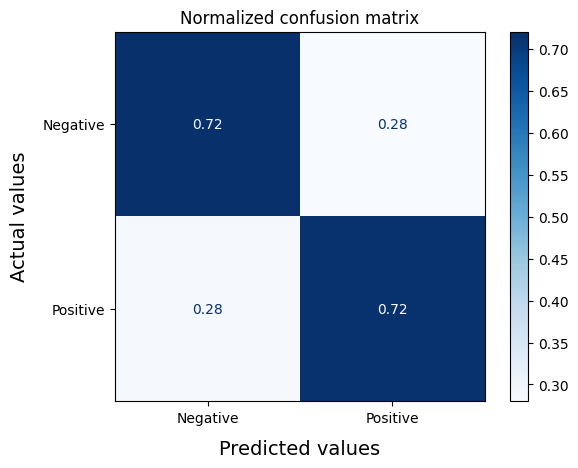

In [181]:
model_Evaluate(classifier_dtree_Count)

## Compare

In [134]:
t = time.time()
y_pred = classifier_nb_Count.predict(X_test_Count)
time_for_predict_nb = time.time() - t
acc_nb = accuracy_score(y_test_Count, y_pred)

t = time.time()
y_pred = classifier_knn_Count.predict(X_test_Count)
time_for_predict_knn = time.time() - t
acc_knn = accuracy_score(y_test_Count, y_pred)

t = time.time()
y_pred = classifier_svm_rbf_Count.predict(X_test_Count)
time_for_predict_svm_rbf = time.time() - t
acc_svm_rbf = accuracy_score(y_test_Count, y_pred)

t = time.time()
y_pred = classifier_svm_linear_Count.predict(X_test_Count)
time_for_predict_svm_linear = time.time() - t
acc_svm_linear = accuracy_score(y_test_Count, y_pred)

t = time.time()
y_pred = classifier_dtree_Count.predict(X_test_Count)
time_for_predict_dtree = time.time() - t
acc_dtree = accuracy_score(y_test_Count, y_pred)

In [135]:
print(f'KNN:           Train: {time_for_train_knn:.3f}s, Predict: {time_for_predict_knn:.3f}s, Accuracy: {acc_knn*100:.2f}%')
print(f'Naive Bayes:   Train: {time_for_train_nb:.3f}s, Predict: {time_for_predict_nb:.3f}s, Accuracy: {acc_nb*100:.2f}%')
print(f'SVM rbf:       Train: {time_for_train_svm_rbf:.3f}s, Predict: {time_for_predict_svm_rbf:.3f}s, Accuracy: {acc_svm_rbf*100:.2f}%')
print(f'SVM linear:    Train: {time_for_train_svm_linear:.3f}s, Predict: {time_for_predict_svm_linear:.3f}s, Accuracy: {acc_svm_linear*100:.2f}%')
print(f'Decision Tree: Train: {time_for_train_dtree:.3f}s, Predict: {time_for_predict_dtree:.3f}s, Accuracy: {acc_dtree*100:.2f}%')

KNN:           Train: 0.013s, Predict: 25.444s, Accuracy: 62.46%
Naive Bayes:   Train: 0.044s, Predict: 0.014s, Accuracy: 85.65%
SVM rbf:       Train: 1651.590s, Predict: 211.273s, Accuracy: 87.51%
SVM linear:    Train: 3696.548s, Predict: 99.278s, Accuracy: 86.35%
Decision Tree: Train: 58.713s, Predict: 0.012s, Accuracy: 71.82%
